In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import keras

from dataset import DataSequence
#import dataset
from model import create_model
from django.db import models

# 工場部品傷検出
1. 工場部品に傷がついているかどうかを判別するモデルを生成せよ。  
   ただし、モデルは下記に定義しているモデル用い、get_param関数のパラメータを調整することとする。  
   また、モデルの傷判別精度は99%以上とし、対象とする工場部品は6つの内どれを選んでもよい。
2. （発展課題）工場部品についた傷に自動で目印をつけて可視化せよ。  
   モデルの各畳み込み層の出力マップを見える化することで、モデルの推論が尤もらしいかも調べよ。

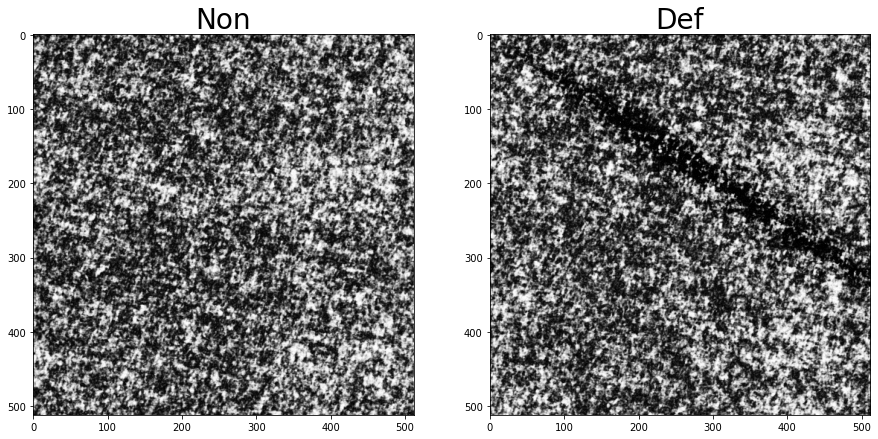

In [2]:
part_class ='Class6'
non_dir = os.path.join(part_class,'non')
def_dir = os.path.join(part_class,'Class6_def')

non_names = os.listdir(non_dir)
def_names = os.listdir(def_dir)

non_path = [os.path.join(non_dir, n) for n in non_names]
def_path = [os.path.join(def_dir, n) for n in def_names]

non_img = cv2.imread(non_path[0])
def_img = cv2.imread(def_path[0])

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(non_img)
ax[1].imshow(def_img)
ax[0].set_title("Non", fontsize=28)
ax[1].set_title("Def", fontsize=28)
plt.show()

# モデルパラメータ調整
下記のget_param関数で設定されている各種パラメータ調整を調整して、モデルを完成させよ。  

In [3]:
#灰度化处理，通道数8，24分
def get_param():
    """
    パラメータ設定
    """
    param = {}

    # training param
    param['batch_size']          = 16          # バッチサイズ#一般都取2的倍数#取32看一下效果
    param['input_size']          = (64, 64)#(128,128)
    param['learning_rate']       = 0.1       # 学習率
    param['momentum']            = 0.6        # SGDのモーメンタム 大小该如何设定#再变化一次动量大小(0.9)，观察结果
    param['shift_learning_rate'] = 0.9#0.1        # 先变成灰度，观察准确率是否有变化，
                                                  #然后调查学習率の変化率#为什么测试集准确率会出现震荡
    param['shift_epoch']         = [15, 25]   # 学習率の変化エポック数
    param['train_epoch']         = 40          # 学習回数#########大约训练到40回就行了
    param['class_weight']        = {0: 1.0,   # 0: 傷無データの重み
                                    1: 1.0}   # 1: 傷有データの重み

    # validation param

    # model param
    param['model_path']    = './class2.hdf5'  # 保存時のモデル名
    param['input_shape']   = (64, 64, 1)    # CNNの入力サイズ#如果class2和class3结果不行的话就把128调大
    param['first_conv_ch'] = 3               # CNNの最初の畳み込みチャネル数#为什么不是3，准确率才能上升
    param['num_block']     = 5                # 畳み込みブロック数#7层没有5层好用#训练层数调大(8)
    param['n_classes']     = 2                # クラス数
    
    # dataset
    param['target_part_class']  = 'Class6'    # 学習対象とする部品の種類
    param['data_split_rate']    = 0.8         # 訓練用、検証用の画像分割率　訓練用：検証用 = x : (1 - x)
    param['train_augment_flag'] = True#False       # 訓練用画像に対するデータ拡張の有無
    param['val_augment_flag']   = False#False       # 検証用画像に対するデータ拡張の有無
    param['horizonal_flip']     = True        # データ拡張：画像の左右反転
    param['vertical_flip']      = True        # データ拡張：画像の上下反転
    param['rotation']           = True        # データ拡張：画像の回転 (0 ~ 20[deg])

    # preprocess param
    param['normalization'] = True             # 入力画像の正規化の有無
    param['gray_scale']    = True             # グレースケール化の有無

    # training log param
    param['output_path'] = 'log'              # ログ保存用フォルダ名

    return param

## 学習準備

In [4]:
# 各種パラメータを取得
param = get_param()

part_class =param['target_part_class']
non_dir = os.path.join(part_class,'non')
def_dir = os.path.join(part_class,'Class6_def')

# 画像名を取得
non_names = os.listdir(non_dir)
def_names = os.listdir(def_dir)

# 画像パスを生成
non_path = [os.path.join(non_dir, n) for n in non_names]
def_path = [os.path.join(def_dir, n) for n in def_names]

# データ数を取得
num_p = len(non_path)
num_f = len(def_path)

# 訓練データと検証データを分割
split_idx_p = int(num_p * param['data_split_rate'])
split_idx_f = int(num_f * param['data_split_rate'])

# 訓練用、検証用の画像パスを取得
train_x = np.array(non_path[:split_idx_p] + def_path[:split_idx_f])
val_x =   np.array(non_path[split_idx_p:] + def_path[split_idx_f:])

# ラベル生成　傷無：0, 傷有:1
label_p = np.zeros(num_p)
label_f = np.ones(num_f)

# 訓練用、検証用のラベルデータを取得
train_y = np.concatenate([label_p[:split_idx_p], label_f[:split_idx_f]], axis=-1)
val_y =   np.concatenate([label_p[split_idx_p:], label_f[split_idx_f:]], axis=-1)

# データジェネレータを生成
train_gen = DataSequence(train_x, train_y, param, param['train_augment_flag'])
val_gen   = DataSequence(val_x, val_y, param, param['val_augment_flag'])

# CNNモデル生成
model = create_model(input_shape=param['input_shape'], 
                        first_ch=param['first_conv_ch'], 
                        num_block=param['num_block'], 
                        n_classes=param['n_classes']) 
# オプティマイザ設定
opt = keras.optimizers.SGD(learning_rate=param['learning_rate'], 
                            momentum=param['momentum'])

# モデルコンパイル
model.compile(optimizer=opt,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])

# モデルサマリ表示
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         30        
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 3)        12        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 3)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 3)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 6)         168   

## 学習開始

In [5]:
def scheduler(epoch, lr):
    """
    学習率スケジューラ
    """
    if epoch < param['shift_epoch'][0]:
        return lr
    elif epoch < param['shift_epoch'][1]:
        return lr * param['shift_learning_rate']
    else:
        return lr *  param['shift_learning_rate'] ** 2

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# 学習開始
history = model.fit(train_gen, 
                              epochs=param['train_epoch'], 
                              validation_data=val_gen, 
                              shuffle=True, 
                              class_weight=param['class_weight'], 
                              callbacks=[callback])

Epoch 1/40
58/58 [==============================] - 29s 452ms/step - loss: 0.4438 - accuracy: 0.8500 - val_loss: 0.3872 - val_accuracy: 0.8696 - lr: 0.1000
Epoch 2/40
58/58 [==============================] - 26s 448ms/step - loss: 0.3748 - accuracy: 0.8663 - val_loss: 0.4036 - val_accuracy: 0.8696 - lr: 0.1000
Epoch 3/40
58/58 [==============================] - 26s 443ms/step - loss: 0.2405 - accuracy: 0.9022 - val_loss: 0.4574 - val_accuracy: 0.8696 - lr: 0.1000
Epoch 4/40
58/58 [==============================] - 26s 445ms/step - loss: 0.1487 - accuracy: 0.9467 - val_loss: 0.5788 - val_accuracy: 0.8696 - lr: 0.1000
Epoch 5/40
58/58 [==============================] - 26s 451ms/step - loss: 0.1185 - accuracy: 0.9620 - val_loss: 0.5060 - val_accuracy: 0.8696 - lr: 0.1000
Epoch 6/40
58/58 [==============================] - 28s 481ms/step - loss: 0.0958 - accuracy: 0.9674 - val_loss: 0.0856 - val_accuracy: 0.9826 - lr: 0.1000
Epoch 7/40
58/58 [==============================] - 27s 466ms/st

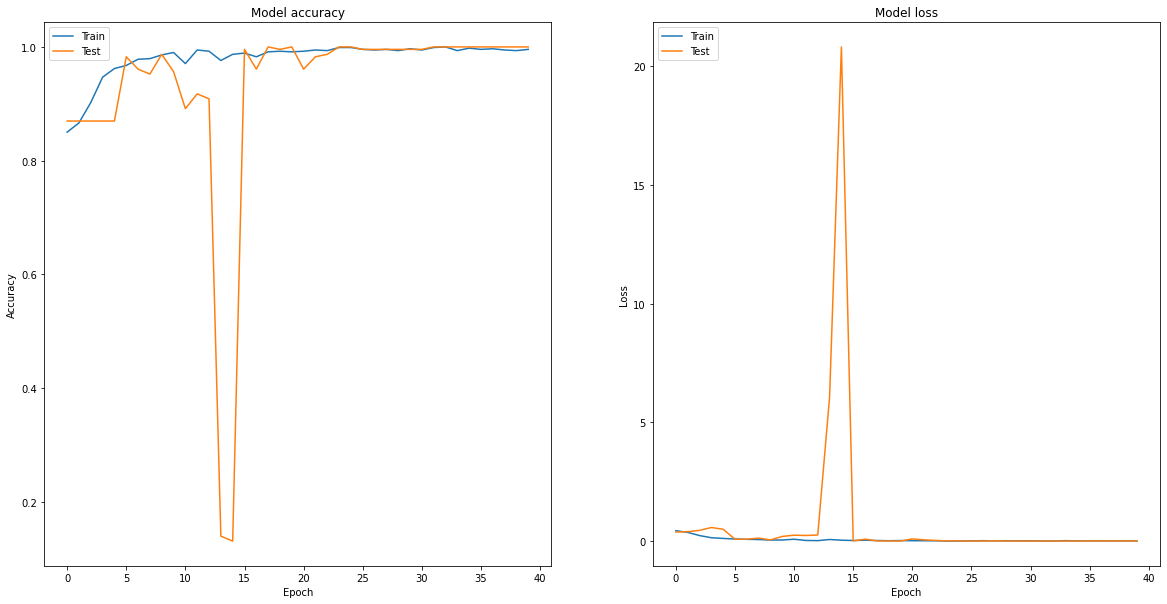

In [6]:
# モデル保存
model.save(param['model_path'])

# ログフォルダ作成
os.makedirs(param['output_path'], exist_ok=True)

# Plot training & validation accuracy values
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
fig_path = os.path.join(param['output_path'], 'loss_acc.png')
plt.savefig(fig_path)

## 発展課題
2. 工場部品についた傷に自動で目印をつけて可視化せよ。  
   モデルの各畳み込み層の出力マップを見える化することで、モデルの推論が尤もらしいかも調べよ。

下記に任意の場所の特徴マップを取得する関数を与える。
この関数を用いてモデルの解析を行ってよい。

In [7]:
def get_layer_output(model, layer_name, inputs):
    """
    任意の層の出力結果（特徴マップ）を取得する関数
        arg1 : model
            学習済モデル
        arg2 : layer_name
            特徴マップを取得したい層の名前
        arg3 : inputs
            入力画像　（モデル推論に用いる前処理済画像）

        return : layer_output
            特徴マップ
    """
    output = model.get_layer(layer_name).output
    model_t = keras.Model(model.input, output)
    layer_output = model_t.predict(inputs)
    return layer_output

## 特徴マップの可視化
下記に抽出したい層の名前を入力して実行すると特徴マップを可視化できる。  
また、層の名前については上記記載のmodel.summary()により確認可能である。

In [8]:
# 傷無、傷有の両方を含む画像バッチを抽出する
for i in range(len(val_gen)):
    imgs, ano = val_gen.__getitem__(i)
    if sum(ano) > 0:
        break

# 必要であれば下記をコメントアウトを外し任意のモデルを読み込んで解析可能
model = keras.models.load_model('class1.hdf5')

# 取得したい層の名前を設定
layer_name = 'input_1'

# 特徴マップ取得
feature_maps = get_layer_output(model, layer_name, imgs)

# 可視化したい画像と特徴マップを選択（添え字はそれ得ること）
img, fmaps = imgs[0], feature_maps[0]

# 特徴マップの選択
fmap = fmaps[:, :, 0]

# 画像表示
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(fmap)
plt.show()
# plt.savefig("feature_map.png")

ValueError: in user code:

    File "c:\users\fupin\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\users\fupin\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\fupin\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\users\fupin\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\users\fupin\appdata\local\programs\python\python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\fupin\appdata\local\programs\python\python39\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 128, 128, 1), found shape=(None, 64, 64, 1)


In [ ]:
len(fmaps)

In [ ]:
len(val_gen)

In [ ]:
# 傷無、傷有の両方を含む画像バッチを抽出する
for i in range(len(val_gen)):
    imgs, ano = val_gen.__getitem__(i)
    if sum(ano) > 0:
        break

# 必要であれば下記をコメントアウトを外し任意のモデルを読み込んで解析可能
model = keras.models.load_model('class1.hdf5')

# 取得したい層の名前を設定
layer_name = 'conv2d_2'

# 特徴マップ取得
feature_maps = get_layer_output(model, layer_name, imgs)

# 可視化したい画像と特徴マップを選択（添え字はそれ得ること）
img, fmaps = imgs[0], feature_maps[0]

# 特徴マップの選択
fmap = fmaps[:, :, 0]

# 画像表示
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(fmap)
plt.show()
# plt.savefig("feature_map.png")

In [ ]:
# 傷無、傷有の両方を含む画像バッチを抽出する
for i in range(len(val_gen)):
    imgs, ano = val_gen.__getitem__(i)
    if sum(ano) > 0:
        break

# 必要であれば下記をコメントアウトを外し任意のモデルを読み込んで解析可能
model = keras.models.load_model('class1.hdf5')

# 取得したい層の名前を設定
layer_name = 'activation'

# 特徴マップ取得
feature_maps = get_layer_output(model, layer_name, imgs)

# 可視化したい画像と特徴マップを選択（添え字はそれ得ること）
img, fmaps = imgs[0], feature_maps[0]

# 特徴マップの選択
fmap = fmaps[:, :, 0]

# 画像表示
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(fmap)
plt.show()
# plt.savefig("feature_map.png")

In [ ]:
# 傷無、傷有の両方を含む画像バッチを抽出する
for i in range(len(val_gen)):
    imgs, ano = val_gen.__getitem__(i)
    if sum(ano) > 0:
        break

# 必要であれば下記をコメントアウトを外し任意のモデルを読み込んで解析可能
model = keras.models.load_model('class1.hdf5')

# 取得したい層の名前を設定
layer_name = 'max_pooling2d'

# 特徴マップ取得
feature_maps = get_layer_output(model, layer_name, imgs)

# 可視化したい画像と特徴マップを選択（添え字はそれ得ること）
img, fmaps = imgs[0], feature_maps[0]

# 特徴マップの選択
fmap = fmaps[:, :, 0]

# 画像表示
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(fmap)
plt.show()
# plt.savefig("feature_map.png")